In [4]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
from os.path import join as oj
import numpy.random as npr
import numpy.linalg as npl

In [27]:
def square_el(x):
    return x * x

def make_data(func, N=4):
    X = np.linspace(0, 100, N)
    X_grid = np.linspace(-80, 120, 1000)
    Y = np.apply_along_axis(func, 0, X)
    Y_grid = np.apply_along_axis(func, 0, X_grid)            
    return X, Y, X_grid, Y_grid


def seed(p):
    s = p.seed
    # set random seed        
    np.random.seed(s) 
    torch.manual_seed(s)    
    random.seed(s)
    
## network
class LinearNet(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size, use_bias=True):
        # num_layers is number of weight matrices
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # for one layer nets
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, output_size, bias=use_bias)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return self.fc[-1](y)

# run

In [67]:
np.linspace(-1, 1, 10)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [71]:
def simple_data(d, N, grid=False):
    if grid:
        X = npr.randn(N, d)
        x0 = X[:, 0]
        X[:, 0] = np.linspace(np.min(x0), np.max(x0), N)
    else:
        X = npr.randn(N, d) # * 1e5
    Y = X[:, 0] # + npr.rand(N) * 0.001
    return X, Y.reshape(-1, 1)

class p:
    hidden_size = 64
    repeats = 1
    opt = 'adam'
    lr = 1e-2
    N = 100
    d = 10 # number of input features
    num_iters = int(1e3)
    num_layers = 1 #, 2, 6]
    use_bias = True
    loss_thresh = 1e-6
    seed = 13
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(p).items()
                 if not attr.startswith('_')}


    
    
def fit(p):
    X, Y = simple_data(p.d, p.N)
    device = 'cuda'
    X_t, Y_t = torch.Tensor(X).to(device), torch.Tensor(Y).to(device)
    r = {}
    seed(p)
    model = LinearNet(num_layers=p.num_layers, input_size=p.d, hidden_size=p.hidden_size, output_size=1, use_bias=p.use_bias).to(device)

    if p.opt == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=p.lr) # wow Adam does way better
    else:
        optimizer = optim.SGD(model.parameters(), lr=p.lr) # 1e6 worked 
    sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(p.num_iters)/3, 2 * int(p.num_iters)/3], gamma=1)


    criterion =  torch.nn.MSELoss()
    losses = []
    ws = []
    grads = []
    for it in tqdm(range(p.num_iters)):
        loss = criterion(model(X_t), Y_t)

        optimizer.zero_grad()            
        loss.backward()
        optimizer.step()
        sched.step(loss)

        losses.append(loss.detach().item())
        ws.append(model.state_dict()['fc.0.weight'].detach().flatten().cpu().numpy())


        grads.append(model.fc[0].weight.grad.detach().flatten().cpu().numpy())
        model.fc[0].weight.grad.data.zero_()

        if loss.item() < p.loss_thresh:
            break


    # saving
    r['model'] = deepcopy(model)
    r['num_lays'] = num_lays
    r['loss'] = losses
    r['w'] = ws
    r['grad'] = grads

    return {**r, **p._dict(p)}, X, Y

device = 'cuda'
num_layers = [1, 2, 3]
rs = []
for i, num_lays in enumerate(num_layers):
    p.num_layers = num_lays
    r, X, Y = fit(p)
    rs.append(r)

  8%|▊         | 78/1000 [00:00<00:02, 387.09it/s]


# analyze results

w ols [ 1.00000000e+00 -9.02056208e-17 -3.46944695e-17 -4.16333634e-17
 -3.46944695e-17 -1.66533454e-16  6.31439345e-16  9.71445147e-17
 -3.12250226e-17 -1.78676518e-16]


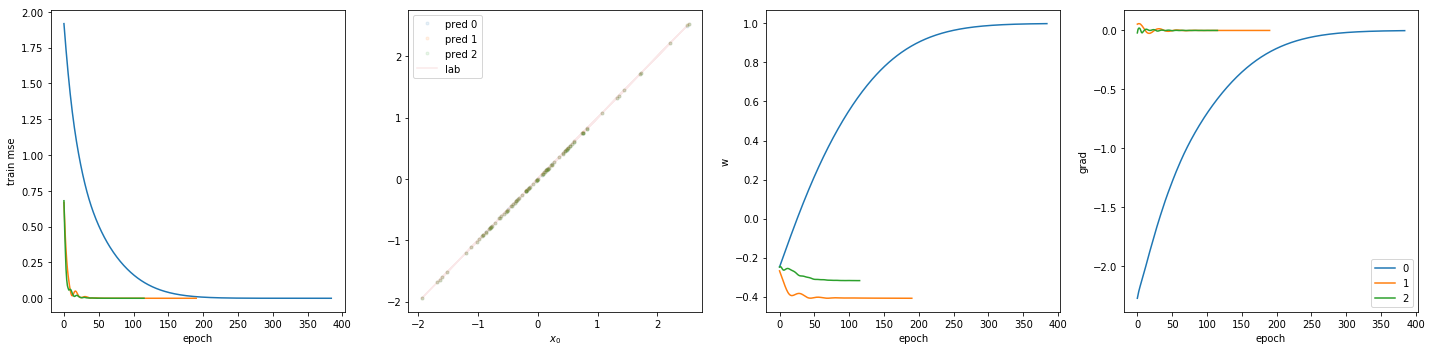

In [75]:
plt.figure(figsize=(20, 5))
results = pd.DataFrame(rs)       

R, C = 1, 4
for i, row in results.iterrows():
    plt.subplot(R, C, 1)
    plt.plot(row.loss, label=str(i))
#     plt.yscale('log')
    plt.ylabel('train mse')
    plt.xlabel('epoch')
    
    
    plt.subplot(R, C, 2)
    m = row.model
    pred = m(torch.Tensor(X).to(device)).cpu().detach().numpy()
    plt.plot(X[:, 0], pred[:, 0], '.', label='pred ' + str(i), alpha=0.1)
    if i == results.shape[0] - 1:
        plt.plot(X[:, 0], Y, label='lab', alpha=0.1)
    plt.xlabel('$x_0$')
    plt.legend()    
    
    plt.subplot(R, C, 3)
    plt.plot(np.array(row['w'])[:, 0])
    plt.ylabel('w')
    plt.xlabel('epoch')

    plt.subplot(R, C, 4)
    plt.plot(np.array(row['grad'])[:, 0], label=str(i))
#     plt.yscale('log')
    plt.ylabel('grad')
    plt.xlabel('epoch')

    plt.legend()


# plt.subplot(R, C, 1)    

plt.tight_layout()


w = npl.pinv(X.T @ X) @ X.T @ Y
print(f'w ols {w.flatten()}') # \nw sgd {row["w"][-1]}')
# print('w', m.state_dict()['fc.0.weight'].item(), 'b', m.state_dict()['fc.0.bias'].item())
# print(model.linear.weight)

plt.show()

4.655824475375482e-06
0.0907256904869063
0.11572839660365748


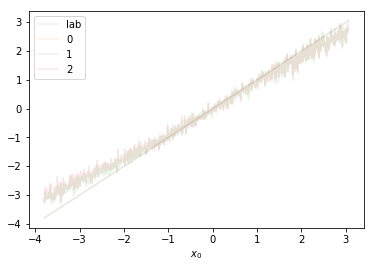

In [76]:
n_test = 1000
X_test, Y_test = simple_data(p.d, n_test, grid=True)

plt.plot(X_test[:, 0], Y_test, label='lab', alpha=0.1)
for i, row in results.iterrows():
    
    m = row.model    
#     plt.subplot(R, C, 2)
    pred = m(torch.Tensor(X_test).to(device)).cpu().detach().numpy()
    plt.plot(X_test[:, 0], pred, label=str(i), alpha=0.1)

    plt.xlabel('$x_0$')
    plt.legend()    
    
    test_mse = np.sum((pred - Y_test)**2) / n_test
    print(test_mse)